## Load Data

In [ ]:
!pip install fastparquet
!pip install pyarrow

     |████████████████████████████████| 1.5 MB 5.3 MB/s 
     |████████████████████████████████| 1.6 MB 35.0 MB/s 
     |████████████████████████████████| 136 kB 45.3 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda:0" if torch.cuda.is_available() else "cpu"
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
df = pd.read_parquet('./BTC-BUSD.parquet')

In [ ]:
df_copy = df.copy()
df_copy.reset_index(drop=False, inplace=True)
df_copy.drop(['volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'],1,inplace=True)
df_copy.info()
df_copy.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252562 entries, 0 to 1252561
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   open_time  1252562 non-null  datetime64[ns]
 1   open       1252562 non-null  float32       
 2   high       1252562 non-null  float32       
 3   low        1252562 non-null  float32       
 4   close      1252562 non-null  float32       
dtypes: datetime64[ns](1), float32(4)
memory usage: 28.7 MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,open_time,open,high,low,close
0,2019-09-19 10:02:00,9881.429688,9881.429688,9881.429688,9881.429688
1,2019-09-19 10:03:00,9881.429688,9881.429688,9881.429688,9881.429688
2,2019-09-19 10:04:00,9878.360352,9878.360352,9878.360352,9878.360352
3,2019-09-19 10:05:00,9878.360352,9878.360352,9878.360352,9878.360352
4,2019-09-19 10:06:00,9878.360352,9878.360352,9878.360352,9878.360352


Text(0, 0.5, 'open')

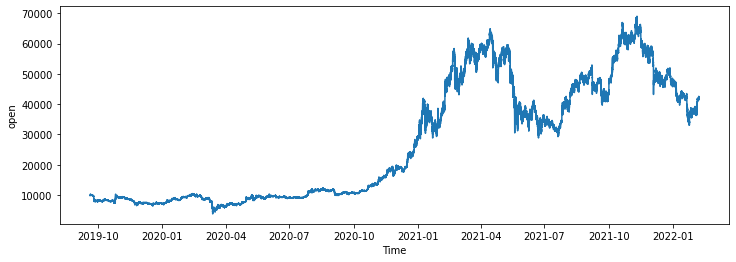

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(df_copy['open_time'], df_copy['open'])
plt.xlabel('Time')
plt.ylabel('open')

# Part I

## Data Preprocess 

In [ ]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    opens = df.open.values.reshape(-1,1)
    lows = df.low.values.reshape(-1,1)
    highs = df.high.values.reshape(-1,1)
    closes = df['close'].values.reshape(-1,1)
    # scale = min_max_scaler.fit(opens + highs + lows + closes)
    scale = min_max_scaler.fit(closes)
    df['open'] = scale.transform(opens)
    df['high'] = scale.transform(highs)
    df['low'] = scale.transform(lows)
    df['close'] = scale.transform(closes)
    return df, scale

def load_data(stock, seq_len):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data); 
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    x_train = data[:train_set_size,:-5,1:]
    # y_train = data[:train_set_size,-5:,1:]
    y_train = data[:train_set_size,-5:,-1]
    
    x_test = data[train_set_size:,:-5,1:]
    # y_test = data[:train_set_size,-5:,1:]
    y_test = data[train_set_size:,-5:,-1]

    time_test = data[train_set_size:,-5:,0]
    
    return [x_train, y_train, x_test, y_test, time_test]

In [ ]:
test_set_size_percentage = 10 
# normalize stock
df_norm, sc = normalize_data(df_copy)

# create train, test data
seq_len = 65 # choose sequence length
x_train, y_train, x_test, y_test, time_test = load_data(df_norm, seq_len)
x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1127247, 60, 4)
y_train.shape =  (1127247, 5)
x_test.shape =  (125250, 60, 4)
y_test.shape =  (125250, 5)


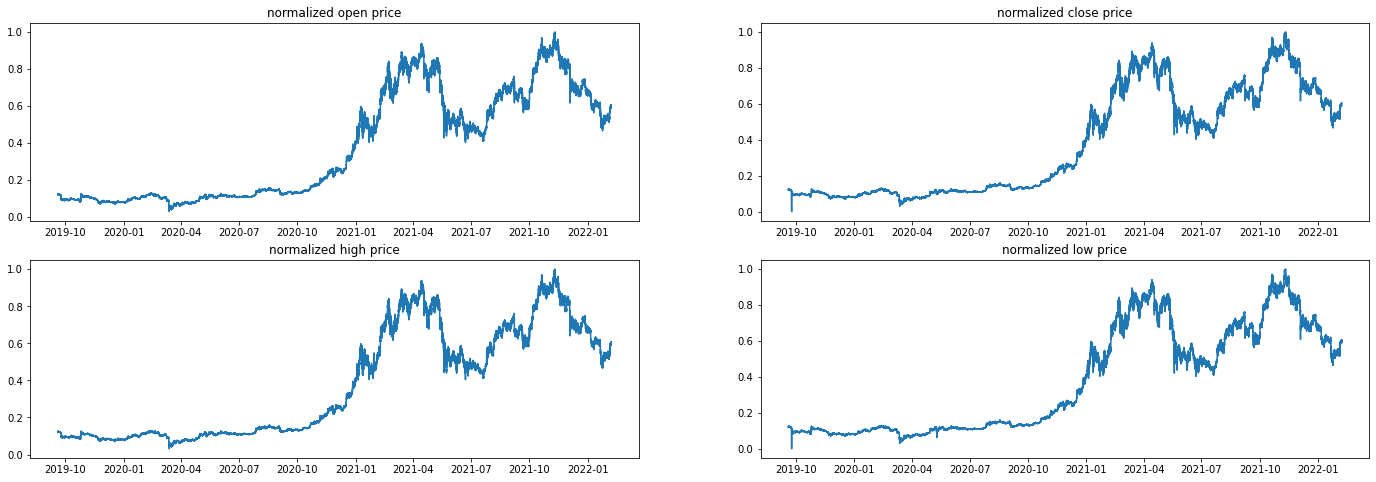

In [ ]:
dic = {1:"open", 2:"close", 3:"high", 4:"low"}
fig = plt.figure(figsize=(24,8))
for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.plot(df_norm['open_time'], df_norm[dic[i]])
    ax.title.set_text(f"normalized {dic[i]} price")

## Train Model 

In [ ]:
class Model(nn.Module):

    def __init__(self, hidden_dim=128):
        super(Model, self).__init__()
        self.lstm = nn.LSTM(input_size=4, hidden_size=hidden_dim, num_layers=2, bidirectional=True, batch_first=True, dropout = 0.2)
        self.fn = nn.Linear(hidden_dim*2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batchsize, max_len, emb_dim = x.shape
        output, (h, c) = self.lstm(x)
        output = self.relu(output[:,-5:,:])
        output = self.fn(output).squeeze(-1)

        return output

In [ ]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
learning_rate = 0.001
batch_size = 256
n_epochs = 10
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

model.train()
cnt = 0
avg_loss = 0.
for epoch in range(int(n_epochs * train_set_size/ batch_size)):
    optimizer.zero_grad()
    x_batch, y_batch = get_next_batch(batch_size)
    x_batch = torch.tensor(x_batch).to(device)
    y_batch = torch.tensor(y_batch)
    y_pred = model(x_batch).cpu()
    loss = criterion(y_pred, y_batch)
    avg_loss += loss.item()
    loss.backward()
    optimizer.step()
    
    cnt += 1
    if cnt % 1000 == 0:
        print("batch count:{}, avg train loss:{}".format(cnt, avg_loss / 1000))
        avg_loss = 0.

torch.save(model.state_dict(), "./parameters.pt")

batch count:1000, avg train loss:0.0015804658355700668
batch count:2000, avg train loss:2.4655723933392437e-05
batch count:3000, avg train loss:1.987893860678014e-05
batch count:4000, avg train loss:1.9953226834786618e-05
batch count:5000, avg train loss:1.4616788848343276e-05
batch count:6000, avg train loss:1.4175933903970872e-05
batch count:7000, avg train loss:1.2471340894535388e-05
batch count:8000, avg train loss:1.260894523920797e-05
batch count:9000, avg train loss:1.1486892622087908e-05
batch count:10000, avg train loss:1.0105547268949522e-05
batch count:11000, avg train loss:9.27413207000427e-06
batch count:12000, avg train loss:9.093468103628766e-06
batch count:13000, avg train loss:8.456140882572073e-06
batch count:14000, avg train loss:8.633795869627648e-06
batch count:15000, avg train loss:7.4005083629344884e-06
batch count:16000, avg train loss:7.1066773427901355e-06
batch count:17000, avg train loss:6.939887575072135e-06
batch count:18000, avg train loss:7.0632788053899

## Prediction

In [ ]:
model = Model().to(device)
model.load_state_dict(torch.load("./parameters.pt"))
model.eval()
criterion = torch.nn.MSELoss(reduction="sum")

In [ ]:
loss = 0.
batch_size = 256
num = math.ceil(test_set_size / batch_size)
start = 0

total_pred = []
with torch.no_grad():
    for cnt in range(num):
        x_batch = x_test[start:min(start+batch_size, test_set_size),:,:]
        y_batch = y_test[start:min(start+batch_size, test_set_size),:]
        y_pred = model(torch.tensor(x_batch).to(device)).cpu()
        loss += criterion(y_pred, torch.tensor(y_batch))
        start += batch_size

        total_pred.append(y_pred.numpy())

print("test mse loss:{}".format(loss / test_set_size))

test mse loss:5.911721382290125e-05


In [ ]:
total_pred = np.concatenate(total_pred, 0)

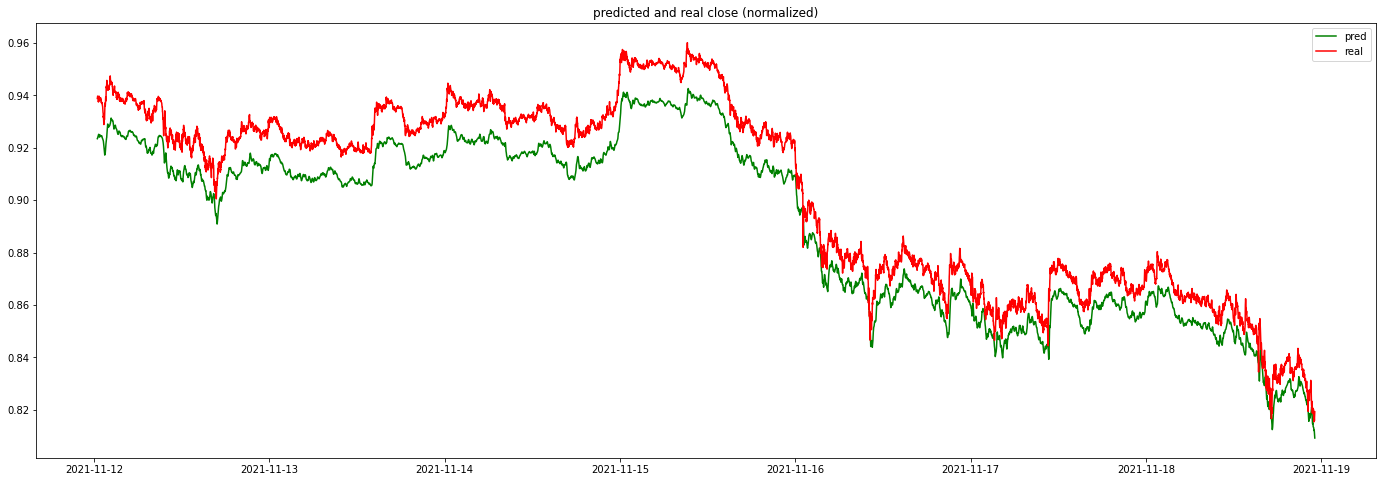

In [ ]:
start = 0
end = 10000
plt.figure(figsize=(24, 8))
plt.plot(time_test[start:end, -1], total_pred[start:end,-1], color="green", label="pred")
plt.plot(time_test[start:end, -1], y_test[start:end,-1], color="red", label="real")
plt.title(f"predicted and real close (normalized)")
plt.legend()

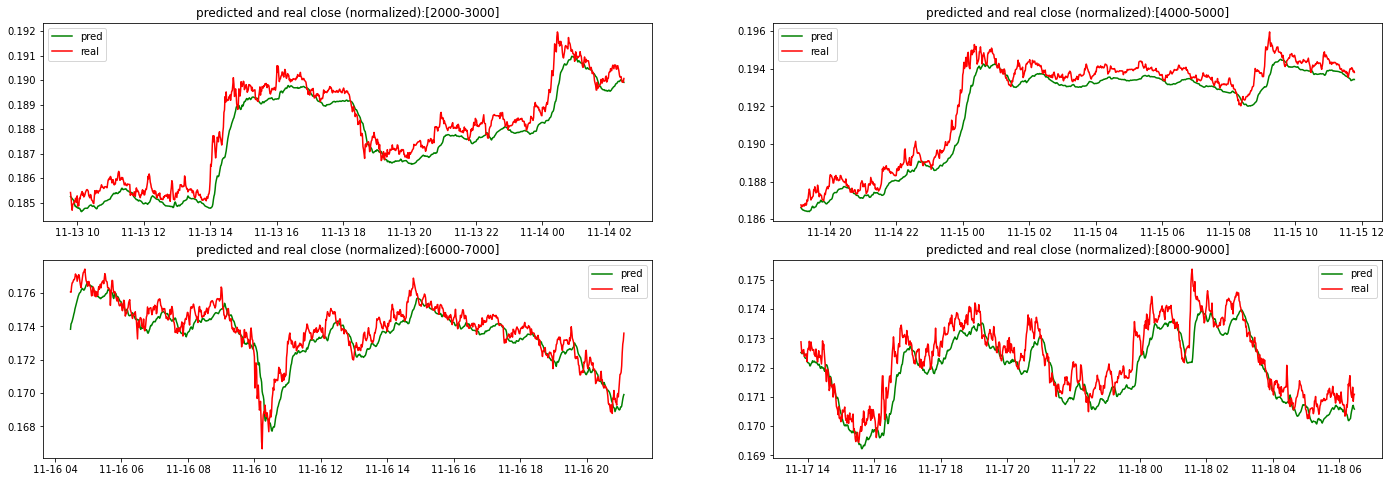

In [ ]:
starts = [2000, 4000, 6000, 8000]
ends = [3000, 5000, 7000, 9000]
fig = plt.figure(figsize=(24,8))

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.plot(time_test[starts[i-1]:ends[i-1], -1], total_pred[starts[i-1]:ends[i-1],-1], color="green", label="pred")
    ax.plot(time_test[starts[i-1]:ends[i-1], -1], y_test[starts[i-1]:ends[i-1],-1], color="red", label="real")
    ax.title.set_text(f"predicted and real close (normalized):[{starts[i-1]}-{ends[i-1]}]")
    ax.legend()

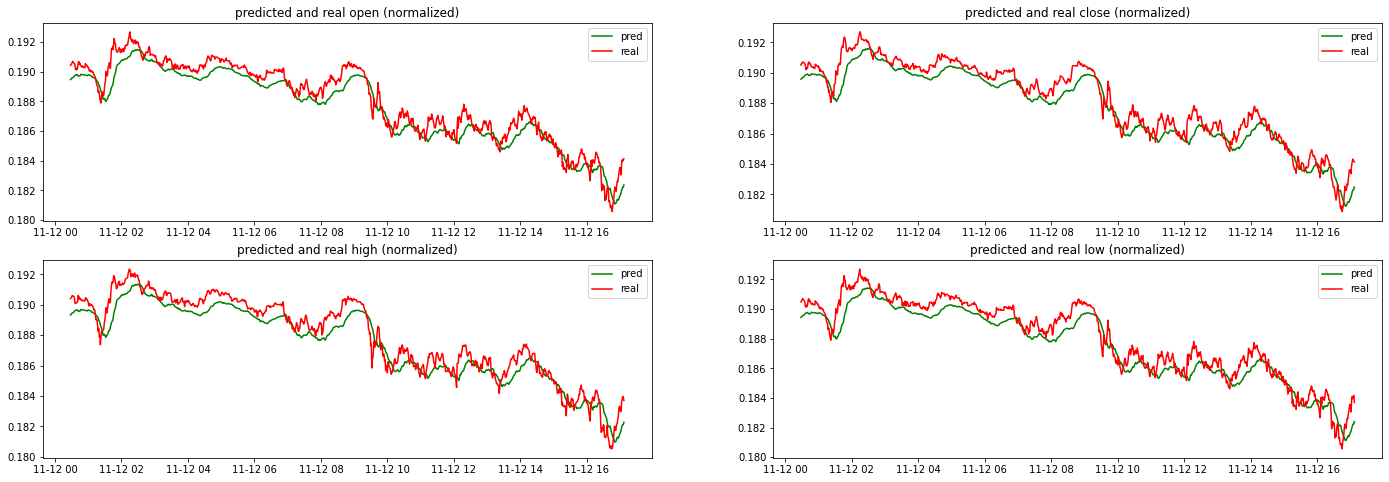

In [ ]:
dic = {1:"open", 2:"close", 3:"high", 4:"low"}
fig = plt.figure(figsize=(24,8))

start = 0
end = 1000
for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.plot(time_test[start:end, -1], total_pred[start:end,-1,i-1], color="green", label="pred")
    ax.plot(time_test[start:end, -1], y_test[start:end,-1,i-1], color="red", label="real")
    ax.title.set_text(f"predicted and real {dic[i]} (normalized)")
    ax.legend()

In [ ]:
# ins_total_pred = sc.inverse_transform(total_pred[:,-1,:])
# ins_y_test = sc.inverse_transform(y_test[:,-1,:])
ins_total_pred = sc.inverse_transform(total_pred)
ins_y_test = sc.inverse_transform(y_test)

mean square error: 53391.88794251497
mean absolute error: 160.85531976047903


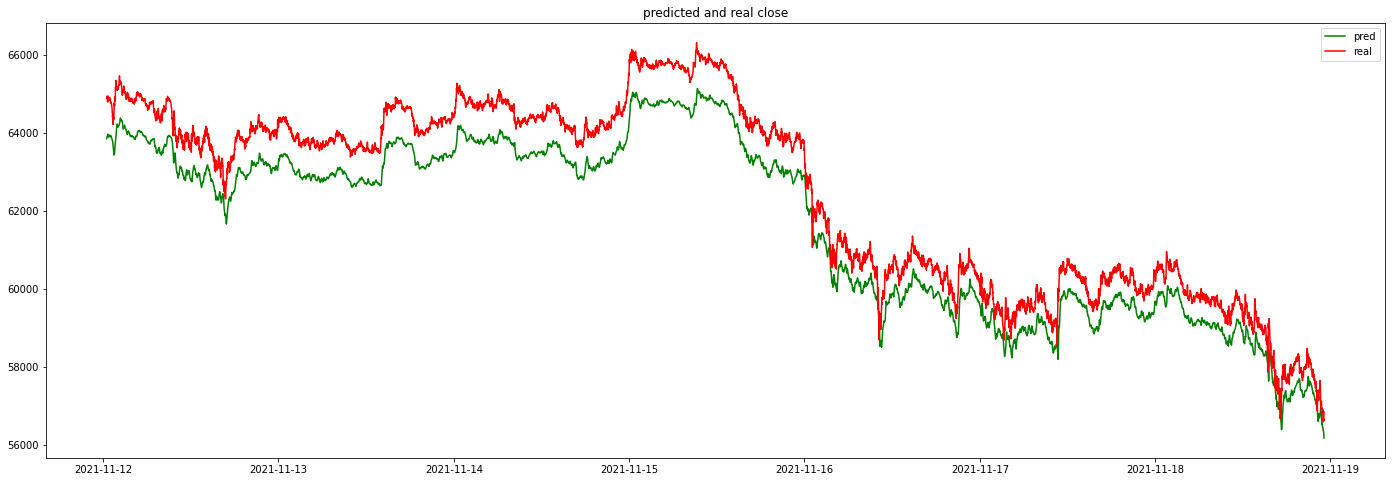

In [ ]:
start = 0
end = 10000
plt.figure(figsize=(24, 8))
plt.plot(time_test[start:end, -1], ins_total_pred[start:end,-1], color="green", label="pred")
plt.plot(time_test[start:end, -1], ins_y_test[start:end,-1], color="red", label="real")
plt.title(f"predicted and real close")
plt.legend()

print("mean square error: {}".format(sum(sum((ins_total_pred - ins_y_test) ** 2)) / (ins_total_pred.shape[0] * 5)))
print("mean absolute error: {}".format(sum(sum(abs(ins_total_pred - ins_y_test))) / (ins_total_pred.shape[0] * 5)))

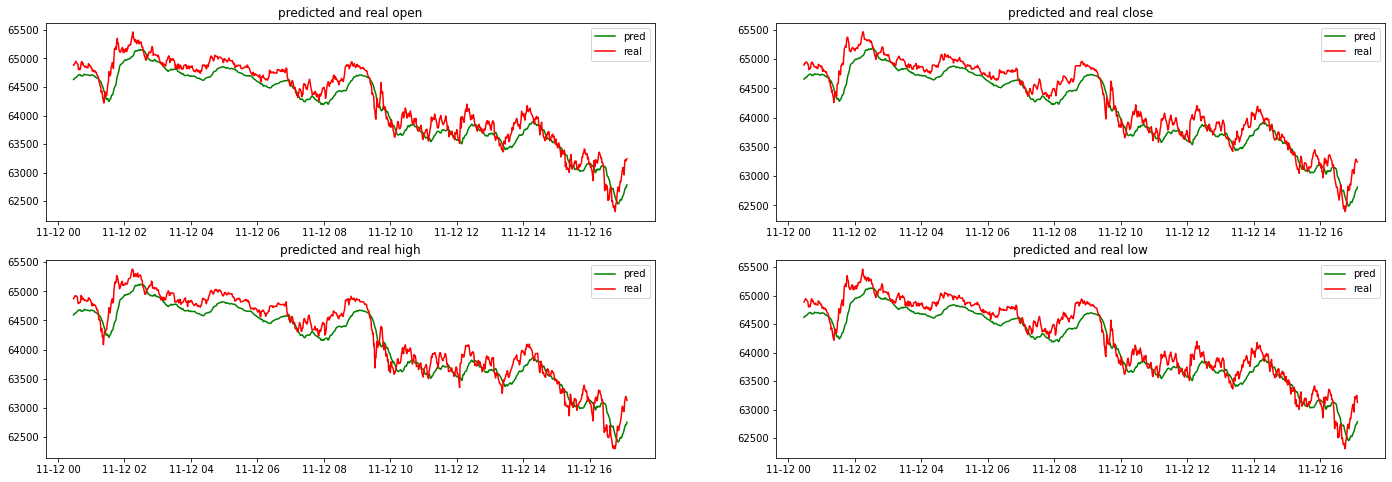

In [ ]:
fig = plt.figure(figsize=(24,8))

start = 0
end = 1000
for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.plot(time_test[start:end, -1], ins_total_pred[start:end,i-1], color="green", label="pred")
    ax.plot(time_test[start:end, -1], ins_y_test[start:end,i-1], color="red", label="real")
    ax.title.set_text(f"predicted and real {dic[i]}")
    ax.legend()

# Part II

## Load External Data 

In [ ]:
fo = pd.read_csv("./Bitcoin_followers.csv")

In [ ]:
fo_copy = fo.reindex(index=fo.index[::-1])
fo_copy.reset_index(drop=True, inplace=True)
fo_copy.info()
fo_copy.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 664 non-null    object 
 1   Reddit Subscribers   664 non-null    int64  
 2   Reddit Active Users  664 non-null    int64  
 3   Twitter Followers    74 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 20.9+ KB


,Date,Reddit Subscribers,Reddit Active Users,Twitter Followers
0,2020-05-07,1405139,8122,NaN
1,2020-05-08,1407416,7578,NaN
2,2020-05-09,1408076,5185,NaN
3,2020-05-10,1410046,7958,NaN
4,2020-05-11,1411910,6038,NaN


In [ ]:
fo_copy.loc[fo_copy["Date"] == "2020-07-12", ["Reddit Subscribers", "Reddit Active Users"]] = [1506000, 3000]

Text(0, 0.5, 'Reddit Active Users')

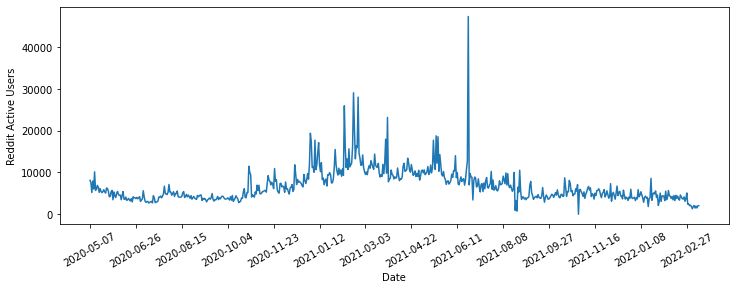

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(fo_copy['Date'], fo_copy['Reddit Active Users'])
plt.xticks(rotation=30)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.xlabel('Date')
plt.ylabel('Reddit Active Users')

Text(0, 0.5, 'Reddit Active Users')

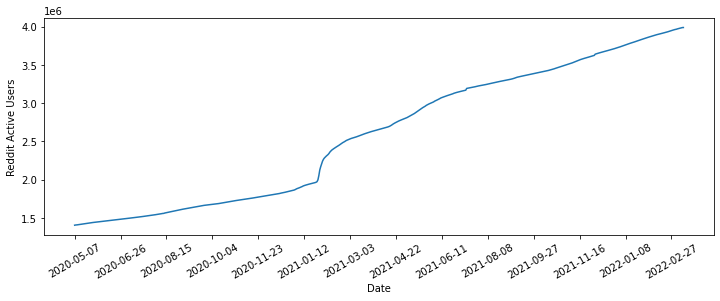

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(fo_copy['Date'], fo_copy['Reddit Subscribers'])
plt.xticks(rotation=30)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.xlabel('Date')
plt.ylabel('Reddit Active Users')

In [ ]:
time2num_users = {}
for i in range(len(fo_copy["Reddit Active Users"])):
    time2num_users[fo_copy["Date"][i]] = fo_copy["Reddit Active Users"][i]

In [ ]:
tweet = pd.read_csv("./Bitcoin_news_tweets.csv")

In [ ]:
tweet_copy = tweet.reindex(index=tweet.index[::-1])
tweet_copy.reset_index(drop=True, inplace=True)
tweet_copy.drop(["Unnamed: 0", "id_str", "user.id"],1,inplace=True)
tweet_copy.info()
tweet_copy.head(-5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489 entries, 0 to 6488
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   full_text       6489 non-null   object 
 1   retweet_count   6489 non-null   int64  
 2   favorite_count  6489 non-null   int64  
 3   score           6489 non-null   float64
 4   time            6489 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 253.6+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,full_text,retweet_count,favorite_count,score,time
0,The real estate platform #Pacaso that speciali...,83,349,0.7579,2021-10-21 04:01:15+00:00
1,Mars4 - Unique NFT Land Plots of the Red Plane...,24,109,0.0000,2021-10-21 05:02:32+00:00
2,Global developer Animoca Brands has announced ...,32,143,0.0000,2021-10-21 06:02:19+00:00
3,"“With Erisx, in a single step, Cboe is able to...",26,101,0.3612,2021-10-21 07:03:02+00:00
4,Young #crypto investors are driven by competit...,40,184,0.0000,2021-10-21 08:03:35+00:00
...,...,...,...,...,...
6479,RT @zhusu: There's prob going to be fewer than...,269,0,0.0000,2022-03-10 00:35:30+00:00
6480,RT @nic__carter: Enjoying the fact that the Wh...,159,0,0.2960,2022-03-10 00:40:58+00:00
6481,👀 https://t.co/kzGmkKVvDM,306,1315,0.0000,2022-03-10 05:01:27+00:00
6482,Inflation sets fresh 40-year high: February CP...,285,1354,0.3182,2022-03-10 15:01:34+00:00


In [ ]:
df_norm["open_time_str"] = df_norm["open_time"].astype(str)

In [ ]:
date_range = pd.date_range("2021-10-21 04:00:00", "2022-03-10 16:00:00")
df_norm_new = df_norm.loc[(df_norm["open_time"]>"2021-10-21 04:00:00") & (df_norm["open_time"]<"2022-03-10 16:00:00") ]

In [ ]:
df_norm_new.info()
df_norm_new.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156718 entries, 1095844 to 1252561
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   open_time      156718 non-null  datetime64[ns]
 1   open           156718 non-null  float32       
 2   high           156718 non-null  float32       
 3   low            156718 non-null  float32       
 4   close          156718 non-null  float32       
 5   open_time_str  156718 non-null  object        
dtypes: datetime64[ns](1), float32(4), object(1)
memory usage: 6.0+ MB


,open_time,open,high,low,close,open_time_str
1095844,2021-10-21 04:01:00,0.191035,0.191311,0.190906,0.191282,2021-10-21 04:01:00
1095845,2021-10-21 04:02:00,0.191282,0.191649,0.191282,0.191436,2021-10-21 04:02:00
1095846,2021-10-21 04:03:00,0.191426,0.191426,0.191029,0.191029,2021-10-21 04:03:00
1095847,2021-10-21 04:04:00,0.191029,0.191076,0.190903,0.190903,2021-10-21 04:04:00
1095848,2021-10-21 04:05:00,0.190902,0.190903,0.190482,0.190512,2021-10-21 04:05:00


In [ ]:
def get_senti_score(scores, times):
    # scores: list of float
    # times: list of str
    time2senti = {}
    for i in range(len(times)):
        time = times[i][:-8]
        time += "00"
        time2senti[time] = time2senti.get(time, 0) + scores[i]
    
    return time2senti

dic = get_senti_score(tweet_copy["score"], tweet_copy["time"])

In [ ]:
dic

{'2021-10-21 04:01:00': 0.7579,
 '2021-10-21 05:02:00': 0.0,
 '2021-10-21 06:02:00': 0.0,
 '2021-10-21 07:03:00': 0.3612,
 '2021-10-21 08:03:00': 0.0,
 '2021-10-21 09:00:00': 0.1396,
 '2021-10-21 10:02:00': 0.0,
 '2021-10-21 11:03:00': 0.4404,
 '2021-10-21 12:02:00': 0.1779,
 '2021-10-21 13:32:00': 0.0,
 '2021-10-21 15:37:00': 0.4939,
 '2021-10-21 17:03:00': -0.0772,
 '2021-10-21 18:31:00': 0.0,
 '2021-10-21 20:33:00': 0.4215,
 '2021-10-21 21:02:00': 0.0,
 '2021-10-21 21:03:00': 0.8074,
 '2021-10-21 22:33:00': 0.0,
 '2021-10-22 00:33:00': 0.2263,
 '2021-10-22 02:34:00': 0.2732,
 '2021-10-22 03:31:00': 0.2263,
 '2021-10-22 04:33:00': 0.2732,
 '2021-10-22 05:02:00': 0.0,
 '2021-10-22 06:33:00': 0.0772,
 '2021-10-22 07:33:00': 0.0,
 '2021-10-22 08:32:00': 0.4019,
 '2021-10-22 09:33:00': 0.0,
 '2021-10-22 10:34:00': 0.0,
 '2021-10-22 11:34:00': 0.024,
 '2021-10-22 12:33:00': 0.3818,
 '2021-10-22 13:03:00': 0.0,
 '2021-10-22 14:33:00': 0.0,
 '2021-10-22 15:33:00': 0.0,
 '2021-10-22 16:32:00

In [ ]:
df_norm_new["senti_score"] = df_norm_new["open_time_str"].apply(lambda x:dic[x] if x in dic.keys() else 0.)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_norm_new[df_norm_new["open_time_str"] == "2021-10-21 07:03:00"]

,open_time,open,high,low,close,open_time_str,senti_score
1096026,2021-10-21 07:03:00,0.189443,0.189738,0.18939,0.189728,2021-10-21 07:03:00,0.3612


In [ ]:
df_norm_new["active users"] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_norm_new["active users"] = df_norm_new["open_time_str"].apply(lambda x:time2num_users[x.split(" ")[0]] if x.split(" ")[0] in time2num_users.keys() else 5000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_norm_new.drop(["open_time_str"], 1, inplace=True)
df_norm_new.info()
df_norm_new.head(-5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156718 entries, 1095844 to 1252561
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   open_time     156718 non-null  datetime64[ns]
 1   open          156718 non-null  float32       
 2   high          156718 non-null  float32       
 3   low           156718 non-null  float32       
 4   close         156718 non-null  float32       
 5   senti_score   156718 non-null  float64       
 6   active users  156718 non-null  int64         
dtypes: datetime64[ns](1), float32(4), float64(1), int64(1)
memory usage: 7.2 MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,open_time,open,high,low,close,senti_score,active users
1095844,2021-10-21 04:01:00,0.191035,0.191311,0.190906,0.191282,0.7579,5421
1095845,2021-10-21 04:02:00,0.191282,0.191649,0.191282,0.191436,0.0000,5421
1095846,2021-10-21 04:03:00,0.191426,0.191426,0.191029,0.191029,0.0000,5421
1095847,2021-10-21 04:04:00,0.191029,0.191076,0.190903,0.190903,0.0000,5421
1095848,2021-10-21 04:05:00,0.190902,0.190903,0.190482,0.190512,0.0000,5421
...,...,...,...,...,...,...,...
1252552,2022-02-06 23:50:00,0.104323,0.104384,0.104244,0.104321,0.0000,4035
1252553,2022-02-06 23:51:00,0.104321,0.104321,0.104115,0.104187,0.0000,4035
1252554,2022-02-06 23:52:00,0.104187,0.104320,0.104003,0.104054,0.0000,4035
1252555,2022-02-06 23:53:00,0.104054,0.104222,0.103981,0.104068,0.0000,4035


## Train with External Data 

In [ ]:
def load_data(stock, seq_len):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data)
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    x_train = data[:train_set_size,:-1,1:]
    y_train = data[:train_set_size,-1,1:5]
    
    x_test = data[train_set_size:,:-1,1:]
    y_test = data[train_set_size:,-1,1:5]

    time_test = data[train_set_size:,-1,0]
    
    return [x_train, y_train, x_test, y_test, time_test]

In [ ]:
test_set_size_percentage = 10 

# create train, test data
seq_len = 20 # choose sequence length
x_train_new, y_train_new, x_test_new, y_test_new, time_test_new = load_data(df_norm_new, seq_len)
x_train_new = np.array(x_train_new, dtype=np.float32)
y_train_new = np.array(y_train_new, dtype=np.float32)
x_test_new = np.array(x_test_new, dtype=np.float32)
y_test_new = np.array(y_test_new, dtype=np.float32)

print('x_train.shape = ',x_train_new.shape)
print('y_train.shape = ', y_train_new.shape)
print('x_test.shape = ', x_test_new.shape)
print('y_test.shape = ',y_test_new.shape)

x_train.shape =  (141028, 19, 6)
y_train.shape =  (141028, 4)
x_test.shape =  (15670, 19, 6)
y_test.shape =  (15670, 4)


In [ ]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.lstm = nn.LSTM(input_size=6, hidden_size=128, num_layers=2, bidirectional=False, batch_first=True, dropout = 0.2)
        self.fn = nn.Linear(128, 4)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batchsize, max_len, emb_dim = x.shape
        output, (h, c) = self.lstm(x)
        output = self.relu(output[:,-1,:])
        output = self.fn(output)

        return output

In [ ]:
index_in_epoch = 0;
perm_array  = np.arange(x_train_new.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train_new, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train_new.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train_new[perm_array[start:end]], y_train_new[perm_array[start:end]]

# parameters
learning_rate = 0.001
batch_size = 128
n_epochs = 1
train_set_size = x_train_new.shape[0]
test_set_size = x_test_new.shape[0]

model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

model.train()
cnt = 0
avg_loss = 0.
for epoch in range(int(n_epochs * train_set_size/ batch_size)):
    optimizer.zero_grad()
    x_batch, y_batch = get_next_batch(batch_size)
    x_batch = torch.tensor(x_batch).to(device)
    y_batch = torch.tensor(y_batch)
    y_pred = model(x_batch).cpu()
    loss = criterion(y_pred, y_batch)
    avg_loss += loss.item()
    loss.backward()
    optimizer.step()
    
    cnt += 1
    if cnt % 1000 == 0:
        print("batch count:{}, avg train loss:{}".format(cnt, avg_loss / 1000))
        avg_loss = 0.

torch.save(model.state_dict(), "./parameters.pt")

batch count:1000, avg train loss:0.0011528979275608436


## Prediction

In [ ]:
model = Model().to(device)
model.load_state_dict(torch.load("./parameters.pt"))
model.eval()
criterion = torch.nn.MSELoss(reduction="sum")

In [ ]:
loss = 0.
batch_size = 256
num = math.ceil(test_set_size / batch_size)
start = 0

total_pred_new = []
with torch.no_grad():
    for cnt in range(num):
        x_batch = x_test_new[start:min(start+batch_size, test_set_size),:,:]
        y_batch = y_test_new[start:min(start+batch_size, test_set_size),:]
        y_pred = model(torch.tensor(x_batch).to(device)).cpu()
        loss += criterion(y_pred, torch.tensor(y_batch))
        start += batch_size

        total_pred_new.append(y_pred.numpy())

print("test mse loss:{}".format(loss / test_set_size))

test mse loss:0.009736298583447933


In [ ]:
total_pred_new = np.concatenate(total_pred_new, 0)

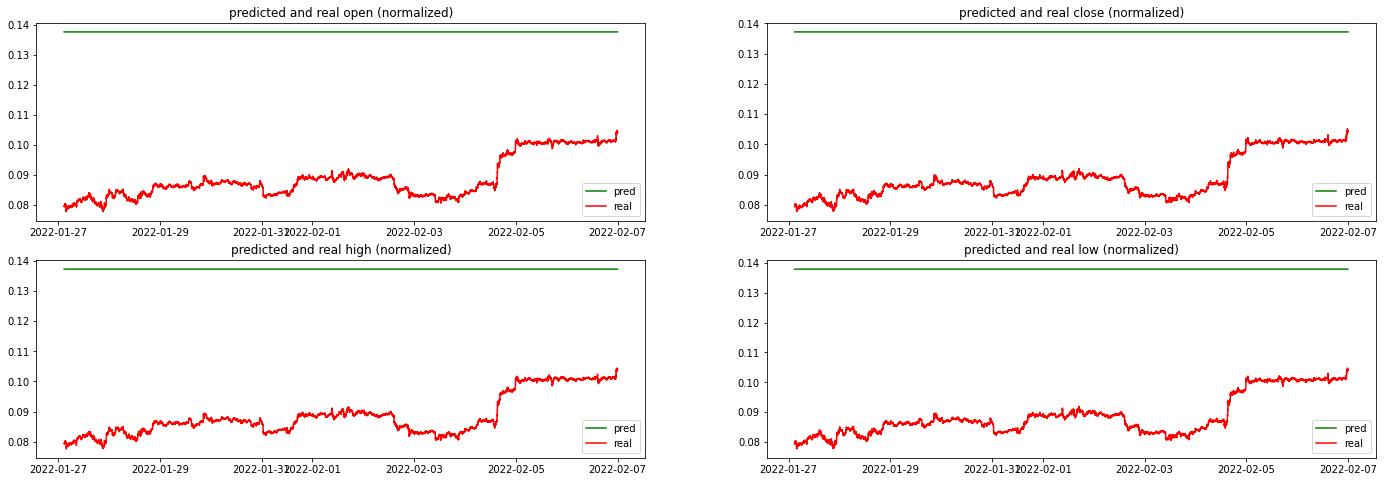

In [ ]:
dic = {1:"open", 2:"close", 3:"high", 4:"low"}
fig = plt.figure(figsize=(24,8))

start = 0
end = test_set_size
for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.plot(time_test_new[start:end], total_pred_new[start:end,i-1], color="green", label="pred")
    ax.plot(time_test_new[start:end], y_test_new[start:end,i-1], color="red", label="real")
    ax.title.set_text(f"predicted and real {dic[i]} (normalized)")
    ax.legend()

In [ ]:
y_test_new

array([[0.07952644, 0.07959376, 0.07940957, 0.07953483],
       [0.07953483, 0.07956871, 0.07936582, 0.07943504],
       [0.07943508, 0.07954074, 0.0793826 , 0.07944438],
       ...,
       [0.10403442, 0.10410458, 0.10389775, 0.10408905],
       [0.10408902, 0.10422221, 0.10408902, 0.10419054],
       [0.10419054, 0.10427885, 0.10410938, 0.10411462]], dtype=float32)

In [ ]:
time_test_new

array([Timestamp('2022-01-27 02:49:00'), Timestamp('2022-01-27 02:50:00'),
       Timestamp('2022-01-27 02:51:00'), ...,
       Timestamp('2022-02-06 23:56:00'), Timestamp('2022-02-06 23:57:00'),
       Timestamp('2022-02-06 23:58:00')], dtype=object)

# Part III (4.19)

## Load External Data

In [ ]:
# df = pd.read_csv("./BTC-0408-0416.csv", header=0)
df = pd.read_csv("./BTC2.csv", header=0)
df["open_time"] = pd.to_datetime(df["open_time"])
df.info()
df.head()

NameError: ignored

Text(0, 0.5, 'close')

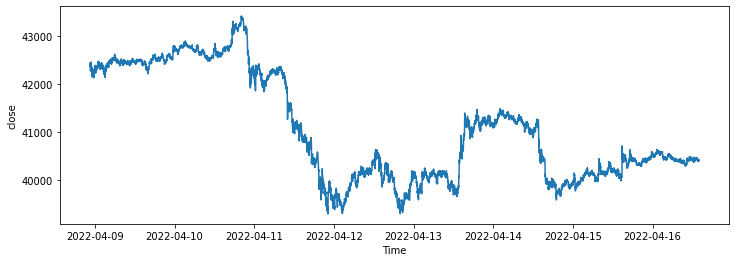

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(df['open_time'], df['close'])
plt.xlabel('Time')
plt.ylabel('close')

In [ ]:
def normalize_data3(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    opens = df.open.values.reshape(-1,1)
    lows = df.low.values.reshape(-1,1)
    highs = df.high.values.reshape(-1,1)
    closes = df.close.values.reshape(-1,1)
    # scale = min_max_scaler.fit(opens + highs + lows + closes)
    scale = min_max_scaler.fit(closes)
    df['open'] = scale.transform(opens)
    df['high'] = scale.transform(highs)
    df['low'] = scale.transform(lows)
    df['close'] = scale.transform(closes)
    return df, scale

def load_data2(stock, seq_len):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len + 1): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data); 
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    x_train = data[:train_set_size,:-5,3:7]
    y_train = data[:train_set_size,-5:,3:7]

    x_test = data[train_set_size:,:-5,3:7]
    y_test = data[train_set_size:,-5:,3:7]

    time_train = data[:train_set_size:,-5:,0]
    time_test = data[train_set_size:,-5:,0]
    
    return [x_train, y_train, x_test, y_test, time_train, time_test]

def load_data3(stock, seq_len):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len + 1): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data); 
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    x_train = data[:train_set_size,:-5,1:]
    y_train = data[:train_set_size,-5:,3:7]
    
    x_test = data[train_set_size:,:-5,1:]
    y_test = data[train_set_size:,-5:,3:7]

    time_train = data[:train_set_size:,-5:,0]
    time_test = data[train_set_size:,-5:,0]
    
    return [x_train, y_train, x_test, y_test, time_train, time_test]

# normalize stock
df_copy = df.copy(deep=True)
df_norm, sc = normalize_data3(df_copy)
# df_norm = df.copy(deep=True)

x_train.shape =  (9843, 60, 4)
y_train.shape =  (9843, 5, 4)
x_test.shape =  (1094, 60, 4)
y_test.shape =  (1094, 5, 4)
time_train.shape =  (9843, 5)
time_test.shape =  (1094, 5)


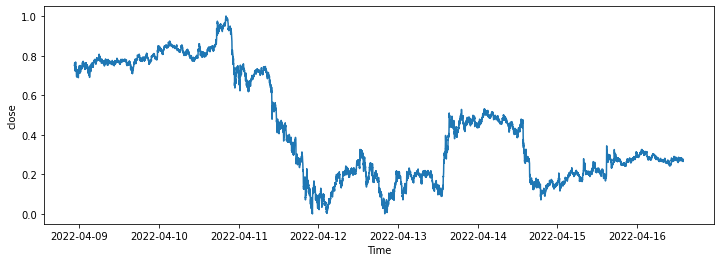

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(df_norm['open_time'], df_norm['close'])
plt.xlabel('Time')
plt.ylabel('close')

test_set_size_percentage = 10 
seq_len = 65 # choose sequence length
x_train, y_train, x_test, y_test, time_train, time_test = load_data2(df_norm, seq_len)
x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)
print("time_train.shape = ",time_train.shape)
print("time_test.shape = ",time_test.shape)

In [ ]:
print(df.loc[10996:,"close"])
print(y_test[-1:, :, -1]) # last 5 min
print(sc.inverse_transform(y_test[-5:,:,-1]))

10996    40389.00
10997    40414.23
10998    40421.83
10999    40409.89
11000    40432.02
Name: close, dtype: float64
[[0.26519567 0.27133894 0.27318946 0.27028218 0.27567065]]
[[40420.3   40394.49  40397.59  40396.02  40389.   ]
 [40394.49  40397.59  40396.02  40389.    40414.227]
 [40397.59  40396.02  40389.    40414.227 40421.832]
 [40396.02  40389.    40414.227 40421.832 40409.89 ]
 [40389.    40414.227 40421.832 40409.89  40432.023]]


## Train

In [ ]:
class Model2(nn.Module):

    def __init__(self, hidden_dim=128):
        super(Model2, self).__init__()
        self.lstm = nn.LSTM(input_size=4, hidden_size=hidden_dim, num_layers=2, bidirectional=True, batch_first=True, dropout = 0.2)
        self.fn = nn.Linear(hidden_dim*2, 4)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batchsize, max_len, emb_dim = x.shape
        output, (h, c) = self.lstm(x)
        output = self.relu(output[:,-5:,:])
        output = self.fn(output)

        return output

class Model3(nn.Module):

    def __init__(self, hidden_dim=128):
        super(Model3, self).__init__()
        self.lstm = nn.LSTM(input_size=11, hidden_size=hidden_dim, num_layers=2, bidirectional=True, batch_first=True, dropout = 0.2)
        self.fn = nn.Linear(hidden_dim*2, 4)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batchsize, max_len, emb_dim = x.shape
        output, (h, c) = self.lstm(x)
        output = self.relu(output[:,-5:,:])
        output = self.fn(output)

        return output

In [ ]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
learning_rate = 0.001
batch_size = 256
n_epochs = 200
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

model = Model2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

model.train()
cnt = 0
avg_loss = 0.
for epoch in range(int(n_epochs * train_set_size/ batch_size)):
    optimizer.zero_grad()
    x_batch, y_batch = get_next_batch(batch_size)
    x_batch = torch.tensor(x_batch, dtype=torch.float32).to(device)
    y_batch = torch.tensor(y_batch, dtype=torch.float32)
    y_pred = model(x_batch).cpu()
    loss = criterion(y_pred, y_batch)
    avg_loss += loss.item()
    loss.backward()
    optimizer.step()
    
    cnt += 1
    if cnt % 100 == 0:
        print("batch count:{},\t avg train loss:{}".format(cnt, avg_loss / 100))
        avg_loss = 0.

torch.save(model.state_dict(), "./parameters_notwt.pt")

batch count:100,	 avg train loss:0.02382496384845581
batch count:200,	 avg train loss:0.0004661324608605355
batch count:300,	 avg train loss:0.00037070981285069137
batch count:400,	 avg train loss:0.0003416701998503413
batch count:500,	 avg train loss:0.000337247467978159
batch count:600,	 avg train loss:0.00031352903650258665
batch count:700,	 avg train loss:0.0003013972110056784
batch count:800,	 avg train loss:0.0003010583316790871
batch count:900,	 avg train loss:0.00028310020090430046
batch count:1000,	 avg train loss:0.00028150064448709597
batch count:1100,	 avg train loss:0.0002718859123706352
batch count:1200,	 avg train loss:0.00026035528964712284
batch count:1300,	 avg train loss:0.0002476847934303805
batch count:1400,	 avg train loss:0.00024245839813374914
batch count:1500,	 avg train loss:0.0002376867078419309
batch count:1600,	 avg train loss:0.00024077254623989575
batch count:1700,	 avg train loss:0.00022029433079296724
batch count:1800,	 avg train loss:0.0002324333286378

## Prediction

In [ ]:
model = Model2()
model.load_state_dict(torch.load("./parameters_notwt.pt"))
model.eval()
criterion = torch.nn.MSELoss(reduction="sum")

loss = 0.
batch_size = 256
num = math.ceil(test_set_size / batch_size)
start = 0

total_pred = []
with torch.no_grad():
    for cnt in range(num):
        x_batch = x_test[start:min(start+batch_size, test_set_size),:,:]
        y_batch = y_test[start:min(start+batch_size, test_set_size),:]
        y_pred = model(torch.tensor(x_batch)).cpu()
        loss += criterion(y_pred, torch.tensor(y_batch))
        start += batch_size

        total_pred.append(y_pred.numpy())

print("test mse loss:{}".format(loss / test_set_size))

test mse loss:0.0006612481665797532


In [ ]:
total_pred = np.concatenate(total_pred, 0)
print(total_pred.shape)

(1094, 5, 4)


mean square error: 547.3075068555759
mean absolute error: 17.985299788619745


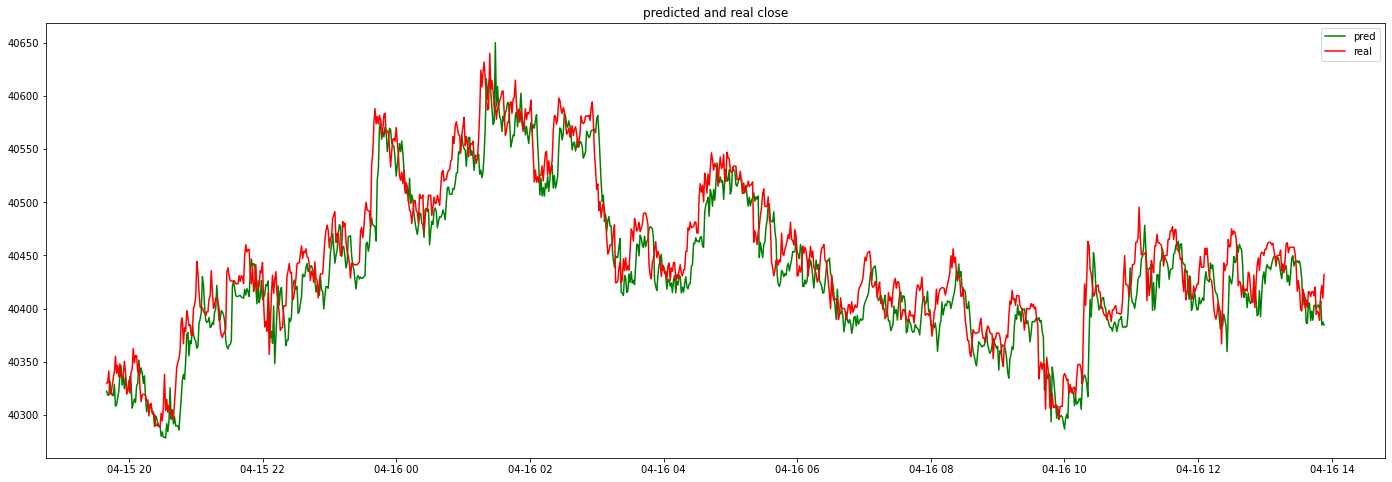

In [ ]:
ins_total_pred = sc.inverse_transform(total_pred[:, :, -1]) # only use close
ins_y_test = sc.inverse_transform(y_test[:, :, -1])

start = 0
end = total_pred.shape[0]
plt.figure(figsize=(24, 8))
plt.plot(time_test[start:end, -1], ins_total_pred[start:end, -1], color="green", label="pred")
plt.plot(time_test[start:end, -1], ins_y_test[start:end, -1], color="red", label="real")

plt.title(f"predicted and real close")
plt.legend()

print("mean square error: {}".format(sum(sum((ins_total_pred - ins_y_test) ** 2)) / (ins_total_pred.shape[0] * ins_total_pred.shape[1])))
print("mean absolute error: {}".format(sum(sum(abs(ins_total_pred - ins_y_test))) / (ins_total_pred.shape[0] * ins_total_pred.shape[1])))

## with tweet

x_train.shape =  (9843, 60, 11)
y_train.shape =  (9843, 5, 4)
x_test.shape =  (1094, 60, 11)
y_test.shape =  (1094, 5, 4)
time_train.shape =  (9843, 5)
time_test.shape =  (1094, 5)


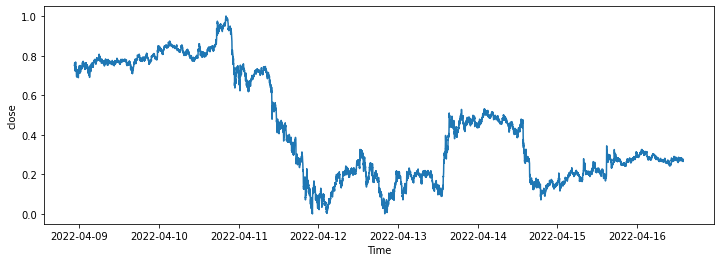

In [ ]:
# normalize stock
df_copy = df.copy(deep=True)
df_norm, sc = normalize_data3(df_copy)
# df_norm = df.copy(deep=True)

plt.figure(figsize=(12, 4))
plt.plot(df_norm['open_time'], df_norm['close'])
plt.xlabel('Time')
plt.ylabel('close')

test_set_size_percentage = 10 
seq_len = 65 # choose sequence length
x_train, y_train, x_test, y_test, time_train, time_test = load_data3(df_norm, seq_len)
x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)
print("time_train.shape = ",time_train.shape)
print("time_test.shape = ",time_test.shape)

In [ ]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
learning_rate = 0.001
batch_size = 512
n_epochs = 200
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

model = Model3().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

model.train()
cnt = 0
avg_loss = 0.
for epoch in range(int(n_epochs * train_set_size/ batch_size)):
    optimizer.zero_grad()
    x_batch, y_batch = get_next_batch(batch_size)
    x_batch = torch.tensor(x_batch).to(device)
    y_batch = torch.tensor(y_batch)
    y_pred = model(x_batch).cpu()
    loss = criterion(y_pred, y_batch)
    avg_loss += loss.item()
    loss.backward()
    optimizer.step()
    
    cnt += 1
    if cnt % 100 == 0:
        print("batch count:{},\t avg train loss:{}".format(cnt, avg_loss / 100))
        avg_loss = 0.

torch.save({"model_params": model.cpu(), "scalar": sc}, "./parameters_twt.pt")

batch count:100,	 avg train loss:0.0780211254581809
batch count:200,	 avg train loss:0.0639703842252493
batch count:300,	 avg train loss:0.06580287601798773


KeyboardInterrupt: ignored

test mse loss:0.000656087533570826
(1094, 5, 4)
mean square error: 	500.9970978062157
mean absolute error: 	16.56475734117916
mean absolute percentage error:	0.0004094884317143526

[[ 6.8242188  8.1640625  5.8085938 16.121094   9.6484375]
 [ 1.9726562  7.0664062 11.8125    10.792969   3.6445312]
 [11.5859375 12.703125   9.238281   0.6875    12.78125  ]
 [13.6484375 16.5625     6.6210938  1.4257812 13.074219 ]]


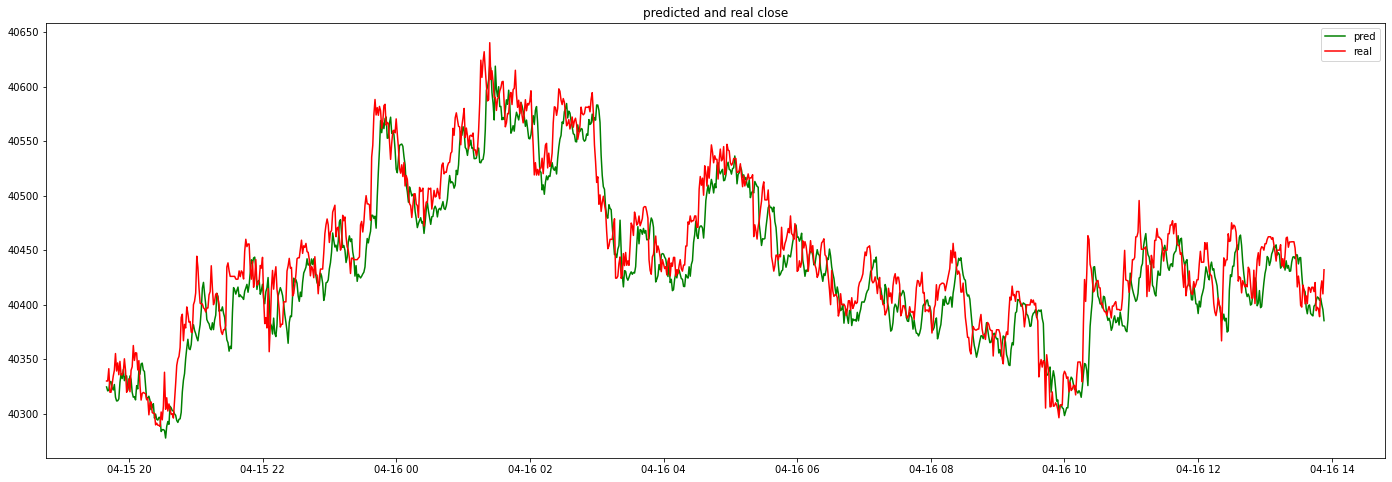

In [ ]:
pretrain = torch.load("./parameters_twt.pt")
model = pretrain["model_params"].to(device)
model.eval()
criterion = torch.nn.MSELoss(reduction="sum")

loss = 0.
batch_size = 512
num = math.ceil(test_set_size / batch_size)
start = 0

total_pred = []
with torch.no_grad():
    for cnt in range(num):
        x_batch = x_test[start:min(start+batch_size, test_set_size),:,:]
        y_batch = y_test[start:min(start+batch_size, test_set_size),:,:]
        y_pred = model(torch.tensor(x_batch).to(device)).cpu()
        loss += criterion(y_pred, torch.tensor(y_batch))
        start += batch_size

        total_pred.append(y_pred.numpy())

print("test mse loss:{}".format(loss / test_set_size))
total_pred = np.concatenate(total_pred, 0)
print(total_pred.shape)
ins_total_pred = sc.inverse_transform(total_pred[:, :, -1]) # only use close
ins_y_test = sc.inverse_transform(y_test[:, :, -1])

start = 0
end = total_pred.shape[0]
plt.figure(figsize=(24, 8))
plt.plot(time_test[:, -1], ins_total_pred[:, -1], color="green", label="pred")
plt.plot(time_test[:, -1], ins_y_test[:, -1], color="red", label="real")
plt.title(f"predicted and real close")
plt.legend()

print("mean square error: \t{}".format(sum(sum((ins_total_pred - ins_y_test) ** 2)) / (ins_total_pred.shape[0] * ins_total_pred.shape[1])))
print("mean absolute error: \t{}".format(sum(sum(abs(ins_total_pred - ins_y_test))) / (ins_total_pred.shape[0] * ins_total_pred.shape[1])))
print("mean absolute percentage error:\t{}".format(sum(sum(abs(ins_total_pred - ins_y_test) / ins_y_test)) / (ins_total_pred.shape[0] * ins_total_pred.shape[1])))
print("")
print(abs(ins_total_pred[4:8, :] - ins_y_test[4:8, :]))

test mse loss:0.002800588496029377
(9843, 5, 4)
mean square error: 	2688.6692878187546
mean absolute error: 	34.65512483490806
mean absolute percentage error:	0.0008459836162833388


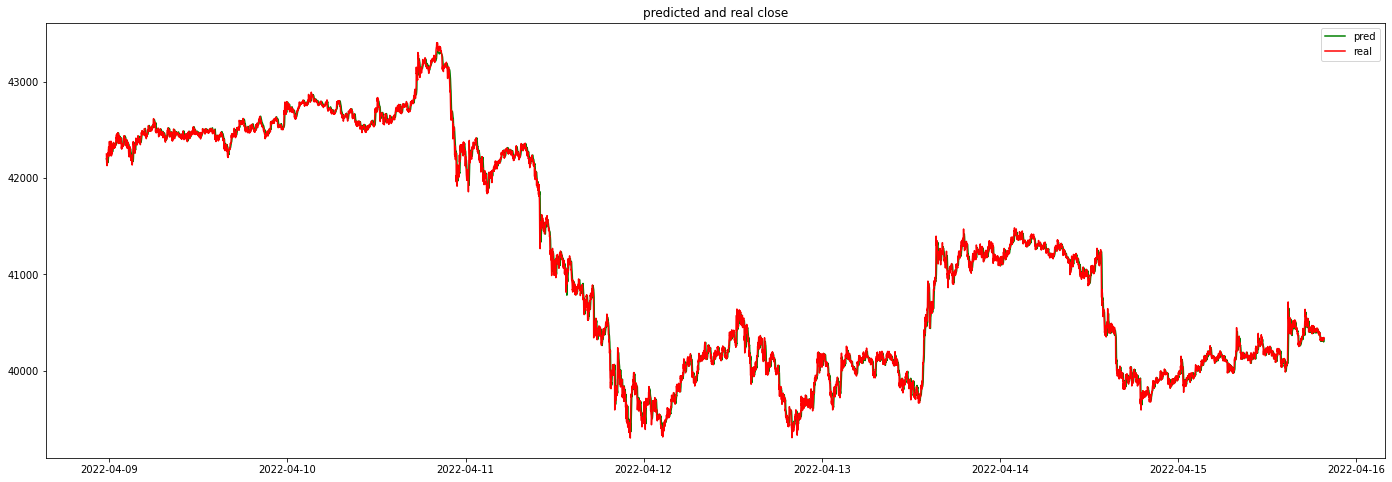

In [ ]:
pretrain = torch.load("./parameters_twt.pt")
model = pretrain["model_params"].to(device)
model.eval()
criterion = torch.nn.MSELoss(reduction="sum")

loss = 0.
batch_size = 512
num = math.ceil(train_set_size / batch_size)
start = 0

total_pred = []
with torch.no_grad():
    for cnt in range(num):
        x_batch = x_train[start:min(start+batch_size, train_set_size),:,:]
        y_batch = y_train[start:min(start+batch_size, train_set_size),:,:]
        y_pred = model(torch.tensor(x_batch).to(device)).cpu()
        loss += criterion(y_pred, torch.tensor(y_batch))
        start += batch_size

        total_pred.append(y_pred.numpy())

print("test mse loss:{}".format(loss / train_set_size))
total_pred = np.concatenate(total_pred, 0)
print(total_pred.shape)
ins_total_pred = sc.inverse_transform(total_pred[:, :, -1]) # only use close
ins_y_test = sc.inverse_transform(y_train[:, :, -1])

start = 0
end = total_pred.shape[0]
plt.figure(figsize=(24, 8))
plt.plot(time_train[:, -1], ins_total_pred[:, -1], color="green", label="pred")
plt.plot(time_train[:, -1], ins_y_test[:, -1], color="red", label="real")
plt.title(f"predicted and real close")
plt.legend()

print("mean square error: \t{}".format(sum(sum((ins_total_pred - ins_y_test) ** 2)) / (ins_total_pred.shape[0] * ins_total_pred.shape[1])))
print("mean absolute error: \t{}".format(sum(sum(abs(ins_total_pred - ins_y_test))) / (ins_total_pred.shape[0] * ins_total_pred.shape[1])))
print("mean absolute percentage error:\t{}".format(sum(sum(abs(ins_total_pred - ins_y_test) / ins_y_test)) / (ins_total_pred.shape[0] * ins_total_pred.shape[1])))

# Final(4.22)

In [6]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda:0" if torch.cuda.is_available() else "cpu"
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [7]:
# df = pd.read_csv("./BTC-0408-0416.csv", header=0)
df = pd.read_csv("./BTC2.csv", header=0)
df["open_time"] = pd.to_datetime(df["open_time"])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11001 entries, 0 to 11000
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   open_time                     11001 non-null  datetime64[ns]
 1   avg                           11001 non-null  float64       
 2   wgtavg                        11001 non-null  float64       
 3   open                          11001 non-null  float64       
 4   high                          11001 non-null  float64       
 5   low                           11001 non-null  float64       
 6   close                         11001 non-null  float64       
 7   volume                        11001 non-null  float64       
 8   quote_asset_volume            11001 non-null  float64       
 9   number_of_trades              11001 non-null  int64         
 10  taker_buy_base_asset_volume   11001 non-null  float64       
 11  taker_buy_quote_asset_volume

,open_time,avg,wgtavg,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2022-04-08 22:33:00,0.106600,-0.076148,42409.00,42409.01,42367.01,42384.64,3.75072,158990.77,254,1.41116,59816.070
1,2022-04-08 22:34:00,0.228277,0.047320,42384.63,42387.50,42344.08,42373.66,5.21452,220892.70,229,1.48407,62871.580
2,2022-04-08 22:35:00,0.142080,0.078871,42369.76,42424.41,42369.75,42415.69,5.10597,216482.45,213,3.03908,128832.950
3,2022-04-08 22:36:00,0.207449,0.232077,42415.68,42453.85,42415.42,42439.52,5.04461,214064.31,252,3.75288,159234.840
4,2022-04-08 22:37:00,0.163528,0.358569,42439.51,42451.54,42412.62,42415.94,2.93812,124666.83,162,0.69743,29594.648


Text(0, 0.5, 'close')

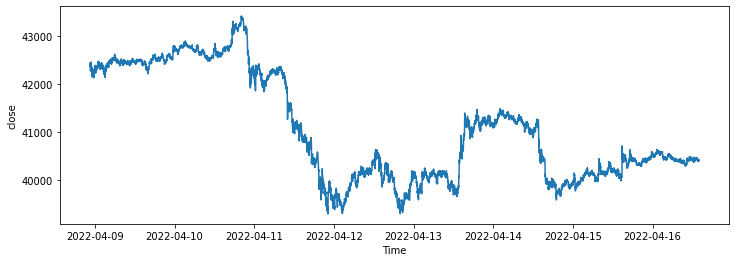

In [3]:
plt.figure(figsize=(12, 4))
plt.plot(df['open_time'], df['close'])
plt.xlabel('Time')
plt.ylabel('close')

Text(0, 0.5, 'close')

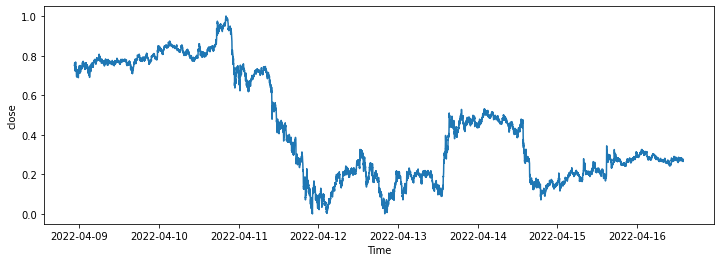

In [4]:
def normalize_data3(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    opens = df.open.values.reshape(-1,1)
    lows = df.low.values.reshape(-1,1)
    highs = df.high.values.reshape(-1,1)
    closes = df.close.values.reshape(-1,1)
    scale = min_max_scaler.fit(closes)
    df['open'] = scale.transform(opens)
    df['high'] = scale.transform(highs)
    df['low'] = scale.transform(lows)
    df['close'] = scale.transform(closes)
    return df, scale

def load_data3(stock, seq_len, k):
    data_raw = stock.values # convert to numpy array
    data = []
    
    for index in range(len(data_raw) - seq_len + 1): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data)

    n = list(range(data.shape[0]))
    test_idx = [i for i in n if i >= data.shape[0]//10*k and i < data.shape[0]//10*(k+1)]
    if k == 9:
      test_idx = [i for i in n if i >= data.shape[0]//10 * k]
    train_idx = [i for i in n if i not in test_idx]
    x_train = data[train_idx,:-5,1:7]
    y_train = data[train_idx,-5:,3:7]
    
    x_test = data[test_idx,:-5,1:7]
    y_test = data[test_idx,-5:,3:7]

    time_train = data[train_idx,-5:,0]
    time_test = data[test_idx,-5:,0]
    
    return [x_train, y_train, x_test, y_test, time_train, time_test]

# normalize stock
df_copy = df.copy(deep=True)
df_norm, sc = normalize_data3(df_copy)
plt.figure(figsize=(12, 4))
plt.plot(df_norm['open_time'], df_norm['close'])
plt.xlabel('Time')
plt.ylabel('close')

In [5]:
class Model3(nn.Module):

    def __init__(self, hidden_dim=128):
        super(Model3, self).__init__()
        self.lstm = nn.LSTM(input_size=6, hidden_size=hidden_dim, num_layers=2, bidirectional=True, batch_first=True, dropout = 0.2)
        self.fn = nn.Linear(hidden_dim*2, 4)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batchsize, max_len, emb_dim = x.shape
        output, (h, c) = self.lstm(x)
        output = self.relu(output[:,-5:,:])
        output = self.fn(output)
        return output

#########################################################################################
class ScaledDotProductAttention(nn.Module):
    def __init__(self, attn_dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, Q, K, V):
        attn = F.softmax(torch.matmul(Q, K.permute(0, 2, 1)) / (K.shape[1] ** 0.5), dim=-1)
        # attn = self.dropout(attn)
        output = torch.matmul(attn, V)
        return output, attn

class MultiHeadAttention(nn.Module):

    def __init__(self, n_head, input_dim, hidden_size=128, dropout=0.1):
        super().__init__()
        self.n_head = n_head
        self.input_dim = input_dim

        self.w_Q = nn.Linear(input_dim, hidden_size*2, bias=False)
        self.w_K = nn.Linear(input_dim, hidden_size*2, bias=False)
        self.w_V = nn.Linear(input_dim, hidden_size*2, bias=False)
        self.attention = ScaledDotProductAttention()
        self.ln = nn.LayerNorm(hidden_size*2, eps=1e-6)
        self.fn = nn.Linear(hidden_size*2, hidden_size*2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        # input: (B, length, d1)
        Q = self.w_Q(input)
        K = self.w_K(input)
        V = self.w_V(input)
        lst = []
        feat_dim = V.shape[2] // self.n_head

        for i in range(self.n_head):
            out, att = self.attention(Q[:, :, (i*feat_dim):((i+1)*feat_dim)],
                                      K[:, :, (i*feat_dim):((i+1)*feat_dim)],
                                      V[:, :, (i*feat_dim):((i+1)*feat_dim)])
            lst.append(out)
        output = torch.cat(lst, dim=-1)
        output = self.fn(output)
        output = self.ln(input + output)

        return output

class Model4(nn.Module):
    def __init__(self, hidden_dim=128):
        super(Model4, self).__init__()

        self.lstm = nn.LSTM(input_size=6, hidden_size=hidden_dim, num_layers=1, batch_first=True, bidirectional=True, dropout=0.2)
        self.transformer_encoder_layer1 = MultiHeadAttention(n_head=2, input_dim=hidden_dim*2)
        self.transformer_encoder_layer2 = MultiHeadAttention(n_head=2, input_dim=hidden_dim*2)

        self.fn = nn.Linear(hidden_dim*2, 4)
        self.relu = nn.ReLU()


    def forward(self, x):
        x, (hn, cn) = self.lstm(x)  # (B, length, hidden_size*2)

        x = self.transformer_encoder_layer1(x)
        # x = self.transformer_encoder_layer2(x)
        output = self.relu(x[:,-5:,:])
        output = self.fn(output)
        return output

In [ ]:
mape_lst = []
mae_lst = []
mse_lst = []
for k in range(10):
  print("Start the {}-th fold of training and test...".format(k+1))
  test_set_size_percentage = 10 
  seq_len = 65 # choose sequence length
  x_train, y_train, x_test, y_test, time_train, time_test = load_data3(df_norm, seq_len, k)
  x_train = np.array(x_train, dtype=np.float32)
  y_train = np.array(y_train, dtype=np.float32)
  x_test = np.array(x_test, dtype=np.float32)
  y_test = np.array(y_test, dtype=np.float32)

  print('x_train.shape = ',x_train.shape)
  print('y_train.shape = ', y_train.shape)
  print('x_test.shape = ', x_test.shape)
  print('y_test.shape = ',y_test.shape)
  print("time_train.shape = ",time_train.shape)
  print("time_test.shape = ",time_test.shape)


  index_in_epoch = 0;
  perm_array  = np.arange(x_train.shape[0])
  np.random.shuffle(perm_array)

  # function to get the next batch
  def get_next_batch(batch_size):
      global index_in_epoch, x_train, perm_array   
      start = index_in_epoch
      index_in_epoch += batch_size
      
      if index_in_epoch > x_train.shape[0]:
          np.random.shuffle(perm_array) # shuffle permutation array
          start = 0 # start next epoch
          index_in_epoch = batch_size
          
      end = index_in_epoch
      return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

  # parameters
  learning_rate = 0.001
  batch_size = 512
  n_epochs = 600
  train_set_size = x_train.shape[0]
  test_set_size = x_test.shape[0]

  model = Model4().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  criterion = torch.nn.MSELoss()

  model.train()
  cnt = 0
  avg_loss = 0.
  for epoch in range(int(n_epochs * train_set_size/ batch_size)):
      optimizer.zero_grad()
      x_batch, y_batch = get_next_batch(batch_size)
      x_batch = torch.tensor(x_batch).to(device)
      y_batch = torch.tensor(y_batch)
      y_pred = model(x_batch).cpu()
      loss = criterion(y_pred, y_batch)
      avg_loss += loss.item()
      loss.backward()
      optimizer.step()
      
      cnt += 1
      if cnt % 1000 == 0:
          print("batch count:{},\t avg train loss:{}".format(cnt, avg_loss / 1000))
          avg_loss = 0.


  model.eval()
  criterion = torch.nn.MSELoss(reduction="sum")

  loss = 0.
  batch_size = 512
  num = math.ceil(test_set_size / batch_size)
  start = 0

  total_pred = []
  with torch.no_grad():
      for cnt in range(num):
          x_batch = x_test[start:min(start+batch_size, test_set_size),:,:]
          y_batch = y_test[start:min(start+batch_size, test_set_size),:,:]
          y_pred = model(torch.tensor(x_batch).to(device)).cpu()
          loss += criterion(y_pred, torch.tensor(y_batch))
          start += batch_size

          total_pred.append(y_pred.numpy())

  print("test mse loss:{}".format(loss / test_set_size))
  total_pred = np.concatenate(total_pred, 0)
  print(total_pred.shape)
  ins_total_pred = sc.inverse_transform(total_pred[:, :, -1]) # only use close
  ins_y_test = sc.inverse_transform(y_test[:, :, -1])

  # start = 0
  # end = total_pred.shape[0]
  # plt.figure(figsize=(24, 8))
  # plt.plot(time_test[:, -1], ins_total_pred[:, -1], color="green", label="pred")
  # plt.plot(time_test[:, -1], ins_y_test[:, -1], color="red", label="real")
  # plt.title(f"predicted and real close")
  # plt.legend()

  mse = sum(sum((ins_total_pred - ins_y_test) ** 2)) / (ins_total_pred.shape[0] * ins_total_pred.shape[1])
  mae = sum(sum(abs(ins_total_pred - ins_y_test))) / (ins_total_pred.shape[0] * ins_total_pred.shape[1])
  mape = sum(sum(abs(ins_total_pred - ins_y_test) / ins_y_test)) / (ins_total_pred.shape[0] * ins_total_pred.shape[1])
  mse_lst.append(mse)
  mae_lst.append(mae)
  mape_lst.append(mape)
  print("mean square error: \t{}".format(mse))
  print("mean absolute error: \t{}".format(mae))
  print("mean absolute percentage error:\t{}".format(mape))
  print("")

Start the 1-th fold of training and test...
x_train.shape =  (9844, 60, 6)
y_train.shape =  (9844, 5, 4)
x_test.shape =  (1093, 60, 6)
y_test.shape =  (1093, 5, 4)
time_train.shape =  (9844, 5)
time_test.shape =  (1093, 5)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


batch count:1000,	 avg train loss:0.0013946283225523075
batch count:2000,	 avg train loss:0.00022152586848824286
batch count:3000,	 avg train loss:0.00019265304484724765
batch count:4000,	 avg train loss:0.00017547916956391418
batch count:5000,	 avg train loss:0.00016407872678246349
batch count:6000,	 avg train loss:0.00015549839481536764
batch count:7000,	 avg train loss:0.00015019794187537628
batch count:8000,	 avg train loss:0.000143012813248788
batch count:9000,	 avg train loss:0.00013769307570328239
batch count:10000,	 avg train loss:0.00013654712947027293
batch count:11000,	 avg train loss:0.0001285532862166292
test mse loss:0.001135181519202888
(1093, 5, 4)
mean square error: 	1131.4932410795975
mean absolute error: 	24.645241737191217
mean absolute percentage error:	0.0005811282449758936

Start the 2-th fold of training and test...
x_train.shape =  (9844, 60, 6)
y_train.shape =  (9844, 5, 4)
x_test.shape =  (1093, 60, 6)
y_test.shape =  (1093, 5, 4)
time_train.shape =  (9844, 5

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


batch count:1000,	 avg train loss:0.0008524064488447038
batch count:2000,	 avg train loss:0.00025419300729117824
batch count:3000,	 avg train loss:0.00022385169626795687
batch count:4000,	 avg train loss:0.0001959811034030281
batch count:5000,	 avg train loss:0.00017478629232209642
batch count:6000,	 avg train loss:0.0015234421563873183
batch count:7000,	 avg train loss:0.0001546683629785548
batch count:8000,	 avg train loss:0.0001499820460812771
batch count:9000,	 avg train loss:0.00014983517087239308
batch count:10000,	 avg train loss:0.00015131824077980127
batch count:11000,	 avg train loss:0.00014970350557996426
test mse loss:0.0007841367623768747
(1093, 5, 4)
mean square error: 	763.406049862763
mean absolute error: 	21.304094950823423
mean absolute percentage error:	0.0004995286464691163

Start the 3-th fold of training and test...
x_train.shape =  (9844, 60, 6)
y_train.shape =  (9844, 5, 4)
x_test.shape =  (1093, 60, 6)
y_test.shape =  (1093, 5, 4)
time_train.shape =  (9844, 5)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


batch count:1000,	 avg train loss:0.0013240816621982957
batch count:2000,	 avg train loss:0.00023816812643781305
batch count:3000,	 avg train loss:0.00021843276865547522
batch count:4000,	 avg train loss:0.0001835547518421663
batch count:5000,	 avg train loss:0.0001527294410407194
batch count:6000,	 avg train loss:0.00014326114789582788
batch count:7000,	 avg train loss:0.00013415749862178927
batch count:8000,	 avg train loss:0.00012945030522678282
batch count:9000,	 avg train loss:0.00012324761845229658
batch count:10000,	 avg train loss:0.00012028051935340045
batch count:11000,	 avg train loss:0.0001160641209280584
test mse loss:0.0052188984118402
(1093, 5, 4)
mean square error: 	5615.924656907594
mean absolute error: 	53.57327953453797
mean absolute percentage error:	0.0012523177557872832

Start the 4-th fold of training and test...
x_train.shape =  (9844, 60, 6)
y_train.shape =  (9844, 5, 4)
x_test.shape =  (1093, 60, 6)
y_test.shape =  (1093, 5, 4)
time_train.shape =  (9844, 5)
ti

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


batch count:1000,	 avg train loss:0.0019454875104274834
batch count:2000,	 avg train loss:0.00015867718921072082
batch count:3000,	 avg train loss:0.00014618850238184677
batch count:4000,	 avg train loss:0.00014115643697732593
batch count:5000,	 avg train loss:0.00013730605754244606
batch count:6000,	 avg train loss:0.00012930899325874634
batch count:7000,	 avg train loss:0.0001259175503801089
batch count:8000,	 avg train loss:0.00011876080768706742
batch count:9000,	 avg train loss:0.00011591907811089186
batch count:10000,	 avg train loss:0.00011275368073256687
batch count:11000,	 avg train loss:0.00010960217286628904
test mse loss:0.006850942503660917
(1093, 5, 4)
mean square error: 	6974.611939615736
mean absolute error: 	58.57363906678866
mean absolute percentage error:	0.0014432125100278025

Start the 5-th fold of training and test...
x_train.shape =  (9844, 60, 6)
y_train.shape =  (9844, 5, 4)
x_test.shape =  (1093, 60, 6)
y_test.shape =  (1093, 5, 4)
time_train.shape =  (9844, 5

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


batch count:1000,	 avg train loss:0.0017566440861992306
batch count:2000,	 avg train loss:0.00023551588371628895
batch count:3000,	 avg train loss:0.0002068861197694787
batch count:4000,	 avg train loss:0.00016946336185355904
batch count:5000,	 avg train loss:0.0001571139183433843
batch count:6000,	 avg train loss:0.00014471102347306443
batch count:7000,	 avg train loss:0.0001379320826890762
batch count:8000,	 avg train loss:0.0001344281617057277
batch count:9000,	 avg train loss:0.0001311024605674902
batch count:10000,	 avg train loss:0.00012446218761760975
batch count:11000,	 avg train loss:0.00012299772412370657
test mse loss:0.004099593497812748
(1093, 5, 4)
mean square error: 	4411.649039341262
mean absolute error: 	52.58897029391583
mean absolute percentage error:	0.0013126449419180407

Start the 6-th fold of training and test...
x_train.shape =  (9844, 60, 6)
y_train.shape =  (9844, 5, 4)
x_test.shape =  (1093, 60, 6)
y_test.shape =  (1093, 5, 4)
time_train.shape =  (9844, 5)
ti

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


batch count:1000,	 avg train loss:0.0011582423447398468
batch count:2000,	 avg train loss:0.00023485922973486595
batch count:3000,	 avg train loss:0.0002160065547650447
batch count:4000,	 avg train loss:0.00019142255018959986
batch count:5000,	 avg train loss:0.00016172653285320847
batch count:6000,	 avg train loss:0.00015103034755884436
batch count:7000,	 avg train loss:0.0001401760320077301
batch count:8000,	 avg train loss:0.00013550715452583973
batch count:9000,	 avg train loss:0.00012871830421499908
batch count:10000,	 avg train loss:0.00012584962336404716
batch count:11000,	 avg train loss:0.00012314797026920132
test mse loss:0.0024495343677699566
(1093, 5, 4)
mean square error: 	2377.7323764867338
mean absolute error: 	35.60864521386093
mean absolute percentage error:	0.0008931146885207893

Start the 7-th fold of training and test...
x_train.shape =  (9844, 60, 6)
y_train.shape =  (9844, 5, 4)
x_test.shape =  (1093, 60, 6)
y_test.shape =  (1093, 5, 4)
time_train.shape =  (9844, 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


batch count:1000,	 avg train loss:0.0014522418140986702
batch count:2000,	 avg train loss:0.00020669081082451158
batch count:3000,	 avg train loss:0.00017296066351991612
batch count:4000,	 avg train loss:0.00016390943794249323
batch count:5000,	 avg train loss:0.00015657069610460893
batch count:6000,	 avg train loss:0.00014589327059366043
batch count:7000,	 avg train loss:0.00014002864680514904
batch count:8000,	 avg train loss:0.0001347648668452166
batch count:9000,	 avg train loss:0.00013026927830651403
batch count:10000,	 avg train loss:0.00012466073547693667
batch count:11000,	 avg train loss:0.00012048264051554725
test mse loss:0.0057280478067696095
(1093, 5, 4)
mean square error: 	5497.615187557182
mean absolute error: 	44.469524102241536
mean absolute percentage error:	0.0010845419799965232

Start the 8-th fold of training and test...
x_train.shape =  (9844, 60, 6)
y_train.shape =  (9844, 5, 4)
x_test.shape =  (1093, 60, 6)
y_test.shape =  (1093, 5, 4)
time_train.shape =  (9844,

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


batch count:1000,	 avg train loss:0.001241515261688619
batch count:2000,	 avg train loss:0.0002291291697183624
batch count:3000,	 avg train loss:0.00021967437239072752
batch count:4000,	 avg train loss:0.00019763705216610105
batch count:5000,	 avg train loss:0.00017516314841486746
batch count:6000,	 avg train loss:0.0011520852557150647
batch count:7000,	 avg train loss:0.0001933992440754082
batch count:8000,	 avg train loss:0.0001909942124475492
batch count:9000,	 avg train loss:0.0001847775314381579
batch count:10000,	 avg train loss:0.00016564934221241856
batch count:11000,	 avg train loss:0.00015086821035220055
test mse loss:0.002836501458659768
(1093, 5, 4)
mean square error: 	2530.3812900274474
mean absolute error: 	34.34881776075023
mean absolute percentage error:	0.0008506744909155619

Start the 9-th fold of training and test...
x_train.shape =  (9844, 60, 6)
y_train.shape =  (9844, 5, 4)
x_test.shape =  (1093, 60, 6)
y_test.shape =  (1093, 5, 4)
time_train.shape =  (9844, 5)
ti

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


batch count:1000,	 avg train loss:0.0017721919563336997
batch count:2000,	 avg train loss:0.0002456933928478975
batch count:3000,	 avg train loss:0.00023154059666558168
batch count:4000,	 avg train loss:0.00019222430229274323
batch count:5000,	 avg train loss:0.00016612667053414042
batch count:6000,	 avg train loss:0.0001511740911882953
batch count:7000,	 avg train loss:0.00014248593997763238
batch count:8000,	 avg train loss:0.00013389700786501635
batch count:9000,	 avg train loss:0.00013146475108078448
batch count:10000,	 avg train loss:0.0002973122601033538
batch count:11000,	 avg train loss:0.00012009362804383272
test mse loss:0.002260098932310939
(1093, 5, 4)
mean square error: 	2038.3513838060385
mean absolute error: 	29.79119396157365
mean absolute percentage error:	0.000740217355447195

Start the 10-th fold of training and test...
x_train.shape =  (9837, 60, 6)
y_train.shape =  (9837, 5, 4)
x_test.shape =  (1100, 60, 6)
y_test.shape =  (1100, 5, 4)
time_train.shape =  (9837, 5)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


batch count:1000,	 avg train loss:0.0014093856615945697
batch count:2000,	 avg train loss:0.0002515232705045491
batch count:3000,	 avg train loss:0.00022622908807534258
batch count:4000,	 avg train loss:0.00019809731725399616
batch count:5000,	 avg train loss:0.001122312670930114
batch count:6000,	 avg train loss:0.00016361633066844662
batch count:7000,	 avg train loss:0.00015386366174789144
batch count:8000,	 avg train loss:0.00015589055867167189
batch count:9000,	 avg train loss:0.0001522880947231897
batch count:10000,	 avg train loss:0.00015265427732811076
batch count:11000,	 avg train loss:0.0001462592691896134
test mse loss:0.0011466877767816186
(1100, 5, 4)
mean square error: 	1021.3664318181818
mean absolute error: 	26.878183948863636
mean absolute percentage error:	0.0006644730134443803



In [ ]:
print(sum(mse_lst)/10)
print(sum(mae_lst)/10)
print(sum(mape_lst)/10)

3236.253159650253
38.178159057054714
0.0009321853627502587


x_train.shape =  (9837, 60, 6)
y_train.shape =  (9837, 5, 4)
x_test.shape =  (1100, 60, 6)
y_test.shape =  (1100, 5, 4)
time_train.shape =  (9837, 5)
time_test.shape =  (1100, 5)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


batch count:1000,	 avg train loss:0.0015168309662258253
batch count:2000,	 avg train loss:0.0002624681265006075
batch count:3000,	 avg train loss:0.00022864011654746719
batch count:4000,	 avg train loss:0.0001864117415098008
batch count:5000,	 avg train loss:0.00017304502832121216
batch count:6000,	 avg train loss:0.00016329536626290064
batch count:7000,	 avg train loss:0.00014887298741086852
batch count:8000,	 avg train loss:0.0004950500268387259
batch count:9000,	 avg train loss:0.00013072120602737413
test mse loss:0.0012502730824053288
(1100, 5, 4)
mean square error: 	1087.4679318181818
mean absolute error: 	28.116262073863638
mean absolute percentage error:	0.0006950162974270908


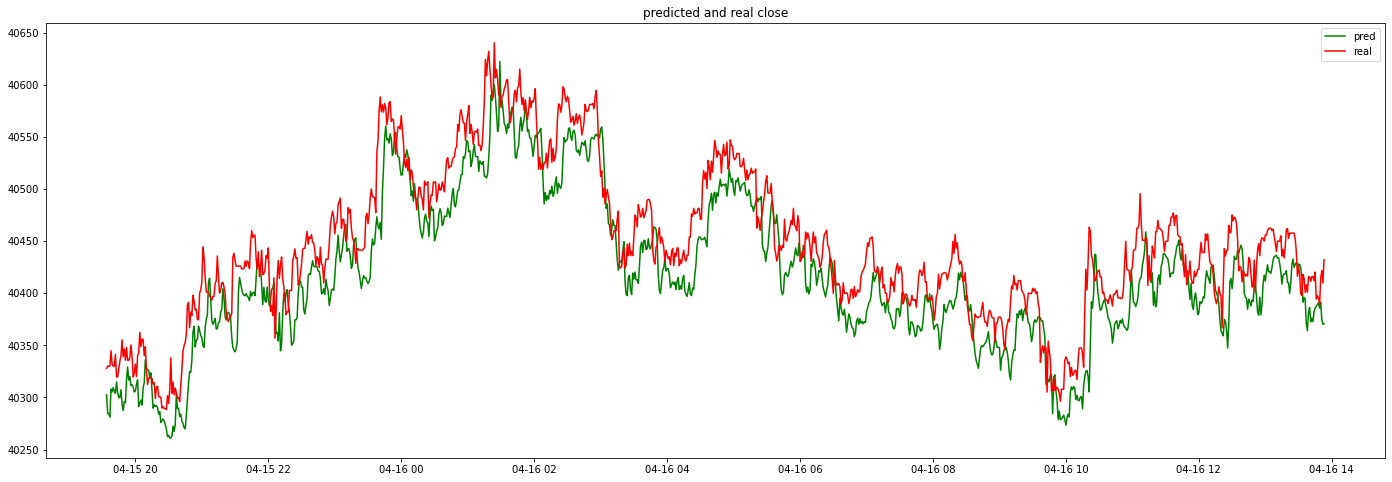

In [16]:
df_copy = df.copy(deep=True)
df_norm, sc = normalize_data3(df_copy)
test_set_size_percentage = 10 
seq_len = 65 # choose sequence length
x_train, y_train, x_test, y_test, time_train, time_test = load_data3(df_norm, seq_len, 9)
x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)
print("time_train.shape = ",time_train.shape)
print("time_test.shape = ",time_test.shape)


index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
learning_rate = 0.001
batch_size = 512
n_epochs = 500
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

model = Model4().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

model.train()
cnt = 0
avg_loss = 0.
for epoch in range(int(n_epochs * train_set_size/ batch_size)):
    optimizer.zero_grad()
    x_batch, y_batch = get_next_batch(batch_size)
    x_batch = torch.tensor(x_batch).to(device)
    y_batch = torch.tensor(y_batch)
    y_pred = model(x_batch).cpu()
    loss = criterion(y_pred, y_batch)
    avg_loss += loss.item()
    loss.backward()
    optimizer.step()
    
    cnt += 1
    if cnt % 1000 == 0:
        print("batch count:{},\t avg train loss:{}".format(cnt, avg_loss / 1000))
        avg_loss = 0.

torch.save({"model_params": model.cpu(), "scalar": sc}, "./transformer_twt.pt")

pretrain = torch.load("./transformer_twt.pt")
model = pretrain["model_params"].to(device)
model.eval()
criterion = torch.nn.MSELoss(reduction="sum")

loss = 0.
batch_size = 512
num = math.ceil(test_set_size / batch_size)
start = 0

total_pred = []
with torch.no_grad():
    for cnt in range(num):
        x_batch = x_test[start:min(start+batch_size, test_set_size),:,:]
        y_batch = y_test[start:min(start+batch_size, test_set_size),:,:]
        y_pred = model(torch.tensor(x_batch).to(device)).cpu()
        loss += criterion(y_pred, torch.tensor(y_batch))
        start += batch_size

        total_pred.append(y_pred.numpy())

print("test mse loss:{}".format(loss / test_set_size))
total_pred = np.concatenate(total_pred, 0)
print(total_pred.shape)
ins_total_pred = sc.inverse_transform(total_pred[:, :, -1]) # only use close
ins_y_test = sc.inverse_transform(y_test[:, :, -1])

start = 0
end = total_pred.shape[0]
plt.figure(figsize=(24, 8))
plt.plot(time_test[:, -1], ins_total_pred[:, -1], color="green", label="pred")
plt.plot(time_test[:, -1], ins_y_test[:, -1], color="red", label="real")
plt.title(f"predicted and real close")
plt.legend()

mse = sum(sum((ins_total_pred - ins_y_test) ** 2)) / (ins_total_pred.shape[0] * ins_total_pred.shape[1])
mae = sum(sum(abs(ins_total_pred - ins_y_test))) / (ins_total_pred.shape[0] * ins_total_pred.shape[1])
mape = sum(sum(abs(ins_total_pred - ins_y_test) / ins_y_test)) / (ins_total_pred.shape[0] * ins_total_pred.shape[1])
print("mean square error: \t{}".format(mse))
print("mean absolute error: \t{}".format(mae))
print("mean absolute percentage error:\t{}".format(mape))